In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
##########################
save_history = True # if true, updates portfolio and platform history files.
gilt_rate = 0.046291 # 10 yr UK government gilt https://tradingeconomics.com/united-kingdom/government-bond-yield
##########################
today = pd.to_datetime('today').normalize()
loans_df = pd.read_csv('data/concatenated.csv')
cash_df = pd.read_csv('data/cash.csv', index_col='platform_account_name')
transactions_df = pd.read_csv('data/transactions.csv')
platform_dict = { 'loanpad':'Loanpad 60d Access','proplend':'Proplend','crowdproperty':'CrowdProperty AutoInvest','invest_fund':'Invest & Fund','assetz_capital':'Assetz Capital','kuflink':'Kuflink Term' }
col_list = ['Paid in capital','Distr capital','Int bearing','Non bearing','Accr int','Residual value','DPI','RVPI','TVPI','Inv mnths','Net AER','Blended LTV','No loans','Avg loan amt','Avg term','Max term','Avg ttm','Max ttm','Avg ext','Ext 90d','Non-perform','Long default','Short default','Int default']
format_dict = { 'Paid in capital': '£{0:,.2f}','Distr capital': '£{0:,.2f}','Int bearing': '£{0:,.2f}','Non bearing': '£{0:,.2f}','Accr int': '£{0:,.2f}','Residual value': '£{0:,.2f}','DPI': '{0:,.2f}', 'RVPI': '{0:,.2f}', 'TVPI' : '{0:,.2f}','Inv mnths': '{:,.0f}','Net AER': '{:,.1%}','Gilt premium': '{:,.1%}','No loans': '{:,.0f}','Avg loan amt': '£{0:,.2f}','Blended LTV': '{:,.0%}','Avg term': '{:,.0f}','Max term': '{:,.0f}','Avg ttm': '{:,.0f}','Max ttm': '{:,.0f}','Avg ext': '{:,.0f}','Ext 90d': '{:,.0%}','Non-perform': '{:,.0%}','Long default': '£{0:,.0f}','Short default': '£{0:,.0f}','Int default': '£{0:,.0f}','Dev sector': '{:.0%}', 'Comm sector': '{:.0%}','No a/c': '{:,.0f}','Avg a/c amt': '£{0:,.0f}'}
colours_list = ['green','blue','red','orange','purple','pink']
def save_platform_csv(platform): # function to update platform_history.csv for a given platform
    exec(platform + "_df = pd.read_csv('data/" + platform + "_history.csv', index_col=0, parse_dates=[0])") # read platform _history.csv
    exec(platform + "_df.loc[today] = platform_row") # append platform row
    exec(platform + "_df.to_csv('data/" + platform + "_history.csv', index=True)") # save platform _history.csv
def show_platform_history(platform):
    filename = f"data/{platform}_history.csv"  # Construct filename using the variable
    try:
        df = pd.read_csv(filename, index_col=0, parse_dates=[0]).sort_index(ascending=False).style.format_index(lambda s: s.strftime('%Y-%m')).format(format_dict)
        return df  # Return the DataFrame
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return None

### Platforms

In [3]:
platform_df = pd.DataFrame(columns=col_list)
for platform in platform_dict:
    platform_account_name = platform_dict[platform]
    platform_loans = loans_df.loc[(loans_df['platform_account_name'] == platform_account_name) & (loans_df['loan_part_status'] != 'Repaid')]
    platform_int_bearing = platform_loans['loan_part_amt'].sum() + cash_df.loc[platform_account_name]['ib_cash'].sum()
    platform_non_bearing = cash_df.loc[platform_account_name]['nonib_cash']
    platform_accrued_int = cash_df.loc[platform_account_name]['accrued_int']
    platform_residual_value = platform_int_bearing + platform_non_bearing + platform_accrued_int
    platform_extended_pct = platform_loans.loc[platform_loans['loan_part_maturity_extended_days'] > 90, 'loan_part_amt'].sum() / platform_loans['loan_part_amt'].sum()
    platform_nonperform_pct = platform_loans.loc[platform_loans['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / platform_loans['loan_part_amt'].sum()
    platform_avg_loan_amt = platform_loans['loan_part_amt'].sum() / platform_loans['loan_portion'].sum()
    platform_transactions = transactions_df.loc[transactions_df['platform_account_name'] == platform_account_name]
    platform_paid_in = platform_transactions.loc[platform_transactions['trx_type'] == 'Paid in', 'trx_amt'].abs().sum()
    platform_distributions = platform_transactions.loc[platform_transactions['trx_type'] == 'Distribution', 'trx_amt'].abs().sum()
    platform_dpi = np.where(platform_distributions != 0, platform_distributions/platform_paid_in, 0)
    platform_rvpi = platform_residual_value / platform_paid_in
    platform_invested_months = (pd.to_datetime('today').date() - pd.to_datetime(platform_transactions['trx_date'].min()).date()).days / 30.437
    platform_row = [platform_paid_in, platform_distributions, platform_int_bearing, platform_non_bearing, platform_accrued_int, platform_residual_value, platform_dpi, platform_rvpi, platform_dpi + platform_rvpi, platform_invested_months, platform_loans['platform_weighted_net_aer'].sum(), platform_loans['platform_weighted_blended_ltv'].sum(), platform_loans['loan_portion'].sum(), platform_avg_loan_amt, platform_loans['platform_weighted_term_months'].sum(), platform_loans['loan_part_term_months'].max(), platform_loans['platform_weighted_ttm_months'].sum(), platform_loans['loan_part_ttm_days'].max()/33.437, platform_loans['platform_weighted_maturity_extended_days'].sum(), platform_extended_pct, platform_nonperform_pct, platform_loans.loc[platform_loans['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),platform_loans.loc[platform_loans['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum()]
    if save_history == True:
        save_platform_csv(platform) # function to update platform_history.csv for all platform accounts
    platform_df.loc[platform_account_name] = platform_row
platform_df.sort_values(by='Residual value', ascending=False).style.format(format_dict)

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
Loanpad 60d Access,"£5,000.00",£0.00,"£5,760.00",£7.08,£0.00,"£5,767.08",0.00,1.15,1.15,31,6.3%,44%,246,£22.51,2,2,2,2,157,39%,0%,£0,£0,£11
Proplend,"£4,000.00",£426.38,"£4,000.00",£26.45,£12.79,"£4,039.24",0.11,1.01,1.12,31,7.6%,50%,4,"£1,000.00",33,36,22,31,0,0%,25%,£0,£0,"£1,000"
Invest & Fund,"£3,350.00",£0.00,"£3,310.23",£323.07,£133.20,"£3,766.50",0.00,1.12,1.12,29,7.2%,66%,16,£206.89,11,18,5,14,0,0%,0%,£0,£0,£0
Kuflink Term,"£2,000.00",£0.00,"£2,048.85",£0.00,£165.19,"£2,214.04",0.00,1.11,1.11,30,8.2%,61%,176,£11.56,24,24,6,5,194,45%,28%,£0,£0,£571
CrowdProperty AutoInvest,"£2,000.00",£827.20,"£1,440.27",£0.00,£0.00,"£1,440.27",0.41,0.72,1.13,29,7.8%,63%,25,£57.61,15,23,4,9,0,0%,83%,"£1,011",£179,£0
Assetz Capital,"£1,009.61",£515.34,£516.01,£11.46,£0.00,£527.47,0.51,0.52,1.03,23,4.1%,58%,122,£4.23,55,103,14,33,0,0%,22%,£16,£31,£67


### Portfolio

In [4]:
portfolio_df = pd.read_csv('data/portfolio_history.csv', index_col=0, parse_dates=[0])
portfolio_paid_in = transactions_df.loc[transactions_df['trx_type'] == 'Paid in', 'trx_amt'].abs().sum()
portfolio_distributions = transactions_df.loc[transactions_df['trx_type'] == 'Distribution', 'trx_amt'].abs().sum()
portfolio_accrued_int = cash_df['accrued_int'].sum()
portfolio_int_bearing = loans_df['loan_part_amt'].sum() + cash_df['ib_cash'].sum()
portfolio_non_bearing = cash_df['nonib_cash'].sum()
portfolio_accrued_int = cash_df['accrued_int'].sum()
portfolio_residual_value = portfolio_int_bearing + portfolio_non_bearing + portfolio_accrued_int
portfolio_dpi = portfolio_distributions / portfolio_paid_in
portfolio_rvpi = portfolio_residual_value / portfolio_paid_in
portfolio_invested_months = (pd.to_datetime('today').date() - pd.to_datetime(transactions_df['trx_date'].min()).date()).days / 30.437
portfolio_weighted_net_aer = loans_df['portfolio_weighted_net_aer'].sum()
portfolio_gilt_premium = portfolio_weighted_net_aer - gilt_rate
portfolio_cagr = (portfolio_dpi + portfolio_rvpi)**(1/(portfolio_invested_months/12))-1
portfolio_row = [portfolio_paid_in, portfolio_distributions, portfolio_int_bearing, portfolio_non_bearing, portfolio_accrued_int, portfolio_residual_value, portfolio_dpi, portfolio_rvpi, portfolio_dpi + portfolio_rvpi, portfolio_invested_months, portfolio_weighted_net_aer, portfolio_gilt_premium, loans_df['portfolio_weighted_blended_ltv'].sum(), loans_df['loan_portion'].sum(), loans_df['loan_part_amt'].sum() / loans_df['loan_portion'].sum(), loans_df['portfolio_weighted_term_months'].sum(),loans_df['loan_part_term_months'].max(),loans_df['portfolio_weighted_ttm_months'].sum(),loans_df['loan_part_ttm_days'].max()/33.437,loans_df['portfolio_weighted_maturity_extended_days'].sum(),loans_df.loc[loans_df['loan_part_maturity_extended_days'] > 90, 'loan_part_amt'].sum() / loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'].isin(['Short Default', 'Long Default', 'Interest Default']), 'loan_part_amt'].sum() / loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Long Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Short Default', 'loan_part_amt'].sum(),loans_df.loc[loans_df['loan_part_status'] == 'Interest Default', 'loan_part_amt'].sum(), loans_df.loc[loans_df['platform_account_sector'] == 'Development']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),loans_df.loc[loans_df['platform_account_sector'] == 'Commercial']['loan_part_amt'].sum()/loans_df['loan_part_amt'].sum(),len(platform_dict),loans_df['loan_part_amt'].sum() / len(platform_dict),]
portfolio_df.loc[today] = portfolio_row
if save_history == True:
    portfolio_df.to_csv('data/portfolio_history.csv', index=True)
portfolio_df.sort_index(ascending=False).style.format_index(lambda s: s.strftime('%Y-%m')).format(format_dict)

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Gilt premium,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default,Dev sector,Comm sector,No a/c,Avg a/c amt
2025-01,"£17,359.61","£1,768.92","£17,075.36",£368.06,£311.18,"£17,754.60",0.10,1.02,1.12,31,7.1%,2.4%,54%,589,£28.59,17,103,9,33,76,18%,17%,"£1,027",£211,"£1,649",73%,27%,6,"£2,806"
2025-01,"£17,359.61","£1,768.92","£17,075.36",£368.06,£311.18,"£17,754.60",0.10,1.02,1.12,31,7.1%,2.4%,54%,589,£28.59,17,103,9,33,76,18%,17%,"£1,027",£211,"£1,649",73%,27%,6,"£2,806"
2024-12,"£17,359.61","£1,621.73","£16,844.84",£541.92,£263.50,"£17,650.26",0.09,1.02,1.11,30,7.1%,2.6%,53%,598,£27.93,17,103,10,35,70,18%,17%,"£1,057",£162,"£1,608",73%,27%,6,"£2,784"
2024-09,"£17,359.61","£1,029.86","£15,907.68","£1,714.01",£204.03,"£17,825.72",0.06,1.03,1.09,27,6.9%,3.0%,54%,588,£26.86,15,103,7,43,64,18%,25%,"£1,084","£1,368","£1,475",77%,23%,6,"£2,632"
2024-08,£nan,£nan,"£15,146.49",£63.23,£nan,"£15,209.72",nan,nan,nan,nan,6.9%,3.0%,54%,587,£25.67,14,103,7,43,44,15%,23%,£999,"£1,128","£1,318",76%,24%,6,"£2,511"
2024-06,£nan,£nan,"£14,783.45",£36.95,£nan,"£14,820.40",nan,nan,nan,nan,6.9%,2.7%,53%,591,£24.82,14,103,7,43,42,16%,17%,£942,£245,"£1,310",75%,25%,6,"£2,445"
2024-03,£nan,£nan,"£14,885.53",£136.50,£nan,"£15,022.03",nan,nan,nan,nan,6.9%,3.0%,54%,571,£25.81,15,86,8,44,49,20%,16%,£721,£400,"£1,224",75%,25%,6,"£2,457"
2023-12,£nan,£nan,"£14,817.62",£117.63,£nan,"£14,935.25",nan,nan,nan,nan,6.9%,3.4%,54%,544,£27.07,15,78,9,47,nan,nan%,14%,£270,£531,"£1,228",74%,26%,6,"£2,454"
2023-11,£nan,£nan,"£14,448.47",£440.01,£nan,"£14,888.48",nan,nan,nan,nan,6.8%,2.5%,54%,552,£25.82,15,78,9,48,nan,nan%,6%,£122,£479,£285,73%,27%,6,"£2,376"
2023-10,£nan,£nan,"£14,741.91",£89.84,£nan,"£14,831.75",nan,nan,nan,nan,6.5%,2.1%,53%,559,£26.04,14,78,7,49,nan,nan%,4%,£122,£333,£200,74%,26%,6,"£2,426"


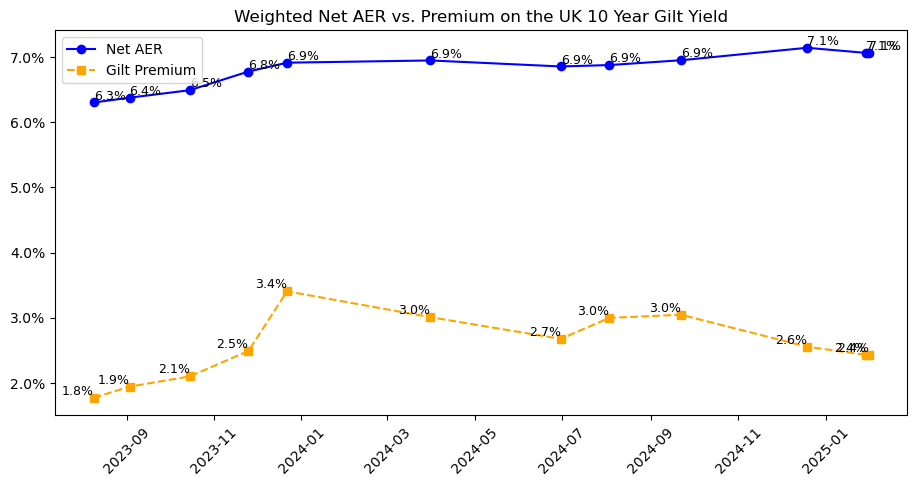

In [5]:
data = {
    'Date': portfolio_df.index.tolist(),
    'Net AER': portfolio_df['Net AER'].tolist(),
    'Gilt Premium': portfolio_df['Gilt premium'].tolist()
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(11, 5))
plt.plot(df['Date'], df['Net AER'], marker='o', label='Net AER', linestyle='-', color='blue')
plt.plot(df['Date'], df['Gilt Premium'], marker='s', label='Gilt Premium', linestyle='--', color='orange')

# Labels and Title
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))  # 1.0 means values are already in decimal
plt.title('Weighted Net AER vs. Premium on the UK 10 Year Gilt Yield')
plt.legend()
plt.xticks(rotation=45)

# Add value labels to the points
for i, txt in enumerate(df['Net AER']):
    plt.text(df['Date'][i], df['Net AER'][i], f"{txt:.1%}", ha='left', va='bottom', fontsize=9)

for i, txt in enumerate(df['Gilt Premium']):
    plt.text(df['Date'][i], df['Gilt Premium'][i], f"{txt:.1%}", ha='right', va='bottom', fontsize=9)

(array([19601., 19662., 19723., 19783., 19844., 19905., 19967., 20028.,
        20089.]),
 [Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01')])

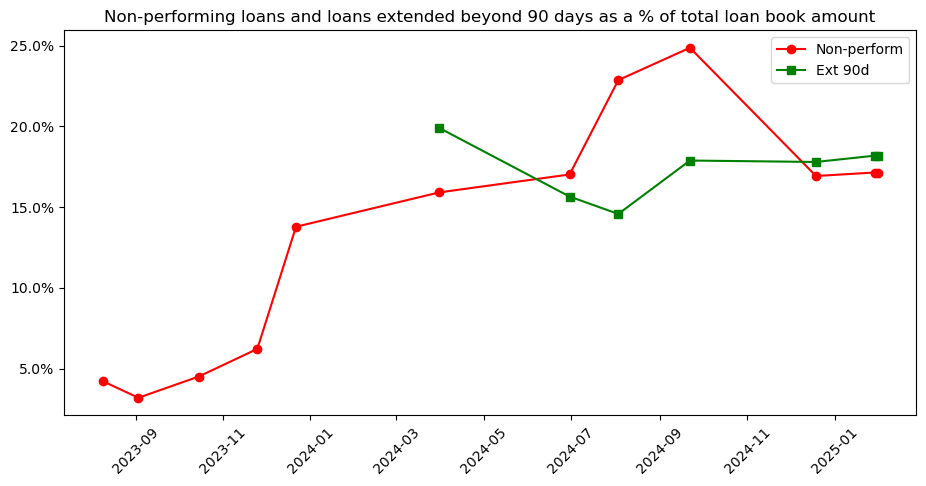

In [6]:
data = {
    'Date': portfolio_df.index.tolist(),
    'Non-perform': portfolio_df['Non-perform'].tolist(),
    'Ext 90d': portfolio_df['Ext 90d'].tolist()
}
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(11, 5))
plt.plot(df['Date'], df['Non-perform'], marker='o', label='Non-perform', linestyle='-', color='red')
plt.plot(df['Date'], df['Ext 90d'], marker='s', label='Ext 90d', linestyle='-', color='green')

# Labels and Title
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))  # 1.0 means values are already in decimal
plt.title('Non-performing loans and loans extended beyond 90 days as a % of total loan book amount')
plt.legend()
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Risk vs Return by Platform Provider')

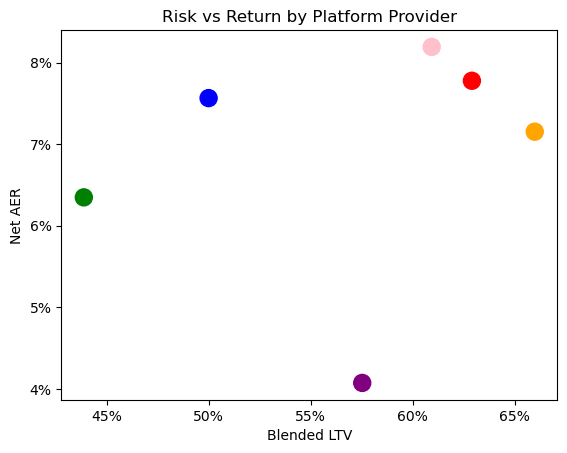

In [7]:
ax = platform_df.plot(kind='scatter', x='Blended LTV', y='Net AER', s=150, c=colours_list)

# Labels and Title
plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))  # 1.0 means values are already in decimal
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))  # 1.0 means values are already in decimal
plt.title('Risk vs Return by Platform Provider')

Text(0.5, 1.0, 'Residual Value as a Proportion of Total Book by Platform Provider')

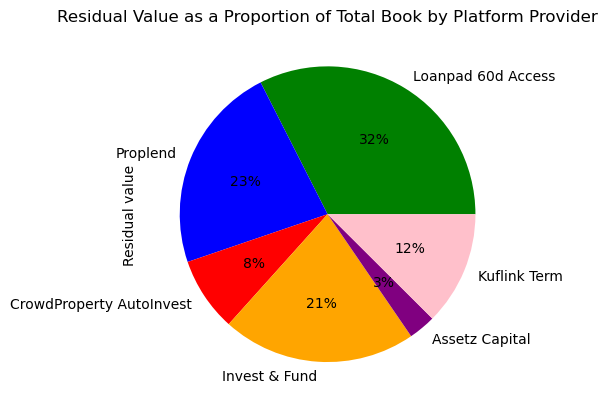

In [8]:
ax = platform_df['Residual value'].plot(kind='pie', colors=colours_list, autopct='%1.0f%%', legend=False)
# Labels and Title
plt.title('Residual Value as a Proportion of Total Book by Platform Provider')

Text(0.5, 1.0, 'Average Loan Amount by Platform Provider')

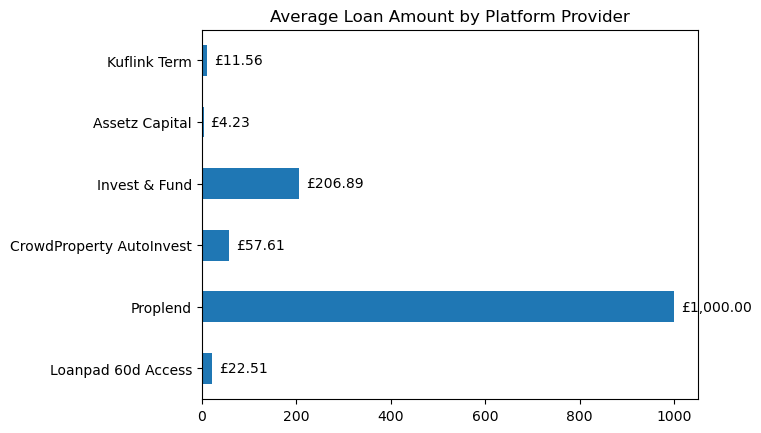

In [9]:
ax = platform_df.plot.barh(y='Avg loan amt', legend=False)
ax.bar_label(ax.containers[0], fmt='£{0:,.2f}', label_type='edge', padding=5)
# Labels and Title
plt.title('Average Loan Amount by Platform Provider')

### Loanpad

In [10]:
show_platform_history('loanpad')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£5,000.00",£0.00,"£5,760.00",£7.08,£0.00,"£5,767.08",0.00,1.15,1.15,31,6.3%,44%,246,£22.51,2,2,2,2,157,39%,0%,£0,£0,£11
2024-12,"£5,000.00",£0.00,"£5,720.00",£3.59,£0.00,"£5,723.59",0.00,1.14,1.14,30,6.5%,44%,243,£22.96,2,2,2,2,143,38%,0%,£0,£0,£11
2024-09,"£5,000.00",£0.00,"£5,630.00",£6.92,£0.00,"£5,636.92",0.00,1.13,1.13,27,6.6%,44%,230,£24.01,2,2,2,2,127,37%,1%,£0,£0,£31
2024-08,£nan,£nan,"£5,580.00",£7.14,£nan,"£5,587.14",nan,nan,nan,nan,6.6%,44%,227,£24.26,2,2,2,2,90,31%,1%,£0,£0,£41
2024-08,£nan,£nan,"£5,580.00",£7.14,£nan,"£5,587.14",nan,nan,nan,nan,6.6%,44%,227,£24.26,2,2,2,2,90,31%,1%,£0,£0,£41
2024-06,£nan,£nan,"£5,550.00",£2.55,£nan,"£5,552.55",nan,nan,nan,nan,6.6%,44%,230,£23.87,2,2,2,2,81,33%,1%,£0,£0,£31
2024-03,£nan,£nan,"£5,450.00",£6.84,£nan,"£5,456.84",nan,nan,nan,nan,6.5%,44%,196,£27.10,2,2,2,2,106,43%,0%,£0,£0,£0
2023-12,£nan,£nan,"£5,360.00",£7.51,£nan,"£5,367.51",nan,nan,nan,nan,6.6%,43%,179,£29.43,2,2,2,2,nan,nan%,1%,£0,£0,£34
2023-11,£nan,£nan,"£5,340.00",£2.74,£nan,"£5,342.74",nan,nan,nan,nan,6.5%,43%,176,£29.23,2,2,2,2,nan,nan%,2%,£0,£0,£127
2023-10,£nan,£nan,"£5,300.00",£3.93,£nan,"£5,303.93",nan,nan,nan,nan,6.4%,43%,174,£29.38,2,2,2,2,nan,nan%,1%,£0,£0,£35


### Proplend

In [11]:
show_platform_history('proplend')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£4,000.00",£426.38,"£4,000.00",£26.45,£12.79,"£4,039.24",0.11,1.01,1.12,31,7.6%,50%,4,"£1,000.00",33,36,22,31,0,0%,25%,£0,£0,"£1,000"
2024-12,"£4,000.00",£407.86,"£4,000.00",£13.98,£9.95,"£4,023.93",0.10,1.01,1.11,30,7.6%,50%,4,"£1,000.00",33,36,24,33,0,0%,25%,£0,£0,"£1,000"
2024-09,"£4,000.00",£324.17,"£3,000.00","£1,016.77",£0.00,"£4,016.77",0.08,1.00,1.09,27,6.7%,50%,3,"£1,000.00",28,36,15,23,0,0%,67%,£0,"£1,000","£1,000"
2024-08,£nan,£nan,"£3,000.00",£5.45,£nan,"£3,005.45",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,17,25,0,0%,67%,£0,"£1,000","£1,000"
2024-08,£nan,£nan,"£3,000.00",£5.45,£nan,"£3,005.45",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,17,25,0,0%,67%,£0,"£1,000","£1,000"
2024-06,£nan,£nan,"£3,000.00",£16.52,£nan,"£3,016.52",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,12,26,0,0%,33%,£0,£0,"£1,000"
2024-03,£nan,£nan,"£3,000.00",£16.49,£nan,"£3,016.49",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,15,29,0,0%,33%,£0,£0,"£1,000"
2023-12,£nan,£nan,"£3,000.00",£16.98,£nan,"£3,016.98",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,18,31,nan,nan%,33%,£0,£0,"£1,000"
2023-11,£nan,£nan,"£3,000.00",£9.79,£nan,"£3,009.79",nan,nan,nan,nan,6.7%,50%,3,"£1,000.00",28,36,19,32,nan,nan%,0%,£0,£0,£0
2023-10,£nan,£nan,"£3,000.00",£13.87,£nan,"£3,013.87",nan,nan,nan,nan,5.7%,47%,3,"£1,000.00",22,24,9,15,nan,nan%,0%,£0,£0,£0


### Invest & Fund

In [12]:
show_platform_history('invest_fund')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£3,350.00",£0.00,"£3,310.23",£323.07,£133.20,"£3,766.50",0.00,1.12,1.12,29,7.2%,66%,16,£206.89,11,18,5,14,0,0%,0%,£0,£0,£0
2024-12,"£3,350.00",£0.00,"£3,106.10",£524.35,£108.20,"£3,738.65",0.00,1.12,1.12,28,7.2%,65%,17,£182.71,11,18,6,15,0,0%,2%,£0,£50,£0
2024-09,"£3,350.00",£0.00,"£2,970.33",£616.39,£100.39,"£3,687.11",0.00,1.10,1.10,25,7.2%,66%,17,£174.73,11,24,7,15,2,0%,8%,£0,£250,£0
2024-08,£nan,£nan,"£3,117.30",£4.54,£nan,"£3,121.84",nan,nan,nan,nan,7.2%,66%,20,£155.87,11,24,7,16,3,1%,0%,£0,£0,£0
2024-08,£nan,£nan,"£3,117.30",£4.54,£nan,"£3,121.84",nan,nan,nan,nan,7.2%,66%,20,£155.87,11,24,7,16,3,1%,0%,£0,£0,£0
2024-06,£nan,£nan,"£2,697.47",£17.88,£nan,"£2,715.35",nan,nan,nan,nan,7.2%,67%,18,£149.86,11,24,7,9,4,1%,0%,£0,£0,£0
2024-03,£nan,£nan,"£2,640.95",£22.43,£nan,"£2,663.38",nan,nan,nan,nan,7.4%,66%,19,£139.00,11,24,7,11,8,2%,0%,£0,£0,£0
2023-12,£nan,£nan,"£2,567.85",£64.89,£nan,"£2,632.74",nan,nan,nan,nan,7.3%,65%,16,£160.49,11,24,7,14,nan,nan%,0%,£0,£0,£0
2023-11,£nan,£nan,"£2,183.81",£417.09,£nan,"£2,600.90",nan,nan,nan,nan,7.0%,66%,16,£136.49,12,24,6,15,nan,nan%,0%,£0,£0,£0
2023-10,£nan,£nan,"£2,509.70",£60.99,£nan,"£2,570.69",nan,nan,nan,nan,6.9%,65%,15,£167.31,13,24,7,16,nan,nan%,0%,£0,£0,£0


### Kuflink

In [13]:
show_platform_history('kuflink')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£2,000.00",£0.00,"£2,048.85",£0.00,£165.19,"£2,214.04",0.00,1.11,1.11,30,8.2%,61%,176,£11.56,24,24,6,5,194,45%,28%,£0,£0,£571
2024-12,"£2,000.00",£0.00,"£2,049.64",£0.00,£145.35,"£2,194.99",0.00,1.10,1.10,29,8.2%,61%,184,£11.14,24,24,7,7,174,41%,27%,£0,£0,£560
2024-12,"£2,000.00",£0.00,"£2,049.64",£0.00,£145.35,"£2,194.99",0.00,1.10,1.10,29,8.2%,61%,184,£11.14,24,24,7,7,174,41%,27%,£0,£0,£560
2024-09,"£2,000.00",£0.00,"£2,056.66",£0.00,£93.39,"£2,150.05",0.00,1.08,1.08,26,8.0%,61%,160,£12.81,24,24,10,9,145,38%,18%,£0,£0,£372
2024-08,£nan,£nan,"£1,050.99",£0.00,£nan,"£1,050.99",nan,nan,nan,nan,7.9%,61%,145,£7.20,24,24,12,11,141,38%,19%,£0,£0,£197
2024-06,£nan,£nan,"£1,050.06",£0.00,£nan,"£1,050.06",nan,nan,nan,nan,7.6%,57%,138,£7.23,24,24,13,12,146,43%,19%,£0,£0,£199
2024-03,£nan,£nan,"£1,050.05",£0.00,£nan,"£1,050.05",nan,nan,nan,nan,7.9%,64%,126,£8.27,24,24,16,15,121,48%,15%,£0,£0,£159
2023-12,£nan,£nan,"£1,050.14",£0.00,£nan,"£1,050.14",nan,nan,nan,nan,8.0%,64%,98,£10.72,24,24,19,18,nan,nan%,12%,£0,£0,£126
2023-11,£nan,£nan,"£1,049.97",£0.00,£nan,"£1,049.97",nan,nan,nan,nan,8.0%,64%,100,£10.50,24,24,20,18,nan,nan%,8%,£0,£0,£85
2023-10,£nan,£nan,"£1,049.96",£0.00,£nan,"£1,049.96",nan,nan,nan,nan,8.0%,65%,100,£10.50,24,24,22,20,nan,nan%,9%,£0,£0,£91


### CrowdProperty

In [14]:
show_platform_history('crowdproperty')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£2,000.00",£827.20,"£1,440.27",£0.00,£0.00,"£1,440.27",0.41,0.72,1.13,29,7.8%,63%,25,£57.61,15,23,4,9,0,0%,83%,"£1,011",£179,£0
2024-12,"£2,000.00",£709.99,"£1,440.27",£0.00,£0.00,"£1,440.27",0.35,0.72,1.08,28,7.8%,63%,25,£57.61,15,23,4,11,-0,0%,76%,"£1,011",£79,£0
2024-09,"£2,000.00",£389.91,"£1,603.78",£0.00,£0.00,"£1,603.78",0.19,0.80,1.00,25,7.7%,62%,28,£57.28,15,23,6,13,-0,0%,71%,"£1,065",£69,£0
2024-08,£nan,£nan,"£1,717.85",£0.00,£nan,"£1,717.85",nan,nan,nan,nan,7.8%,62%,30,£57.26,15,23,6,15,0,0%,63%,£979,£100,£0
2024-08,£nan,£nan,"£1,717.85",£0.00,£nan,"£1,717.85",nan,nan,nan,nan,7.8%,62%,30,£57.26,15,23,6,15,0,0%,63%,£979,£100,£0
2024-06,£nan,£nan,"£1,775.99",£0.00,£nan,"£1,775.99",nan,nan,nan,nan,7.9%,62%,30,£59.20,14,23,7,16,0,0%,64%,£918,£219,£0
2024-03,£nan,£nan,"£1,992.26",£90.74,£nan,"£2,083.00",nan,nan,nan,nan,8.4%,66%,33,£60.37,14,23,9,19,0,0%,54%,£695,£375,£0
2023-12,£nan,£nan,"£2,041.02",£28.25,£nan,"£2,069.27",nan,nan,nan,nan,8.1%,66%,35,£58.31,14,21,7,13,nan,nan%,37%,£248,£500,£0
2023-11,£nan,£nan,"£2,053.02",£10.39,£nan,"£2,063.41",nan,nan,nan,nan,7.9%,66%,33,£62.21,14,21,6,14,nan,nan%,27%,£100,£448,£0
2023-10,£nan,£nan,"£2,043.56",£11.05,£nan,"£2,054.61",nan,nan,nan,nan,7.7%,66%,33,£61.93,14,21,6,17,nan,nan%,20%,£100,£319,£0


### AssetzCapital

In [15]:
show_platform_history('assetz_capital')

,Paid in capital,Distr capital,Int bearing,Non bearing,Accr int,Residual value,DPI,RVPI,TVPI,Inv mnths,Net AER,Blended LTV,No loans,Avg loan amt,Avg term,Max term,Avg ttm,Max ttm,Avg ext,Ext 90d,Non-perform,Long default,Short default,Int default
2025-01,"£1,009.61",£515.34,£516.01,£11.46,£0.00,£527.47,0.51,0.52,1.03,23,4.1%,58%,122,£4.23,55,103,14,33,0,0%,22%,£16,£31,£67
2024-12,"£1,009.61",£503.88,£528.83,£0.00,£0.00,£528.83,0.50,0.52,1.02,22,4.1%,57%,125,£4.23,54,103,16,35,0,0%,22%,£46,£33,£37
2024-09,"£1,009.61",£315.78,£646.91,£73.93,£0.00,£720.84,0.31,0.71,1.03,19,4.1%,59%,150,£4.31,53,103,15,43,0,0%,22%,£19,£49,£72
2024-08,£nan,£nan,£680.35,£46.10,£nan,£726.45,nan,nan,nan,nan,4.1%,59%,162,£4.20,53,103,16,43,0,0%,19%,£19,£28,£80
2024-08,£nan,£nan,£680.35,£46.10,£nan,£726.45,nan,nan,nan,nan,4.1%,59%,162,£4.20,53,103,16,43,0,0%,19%,£19,£28,£80
2024-06,£nan,£nan,£709.93,£0.00,£nan,£709.93,nan,nan,nan,nan,4.1%,59%,172,£4.13,52,103,17,43,0,0%,18%,£24,£26,£80
2024-03,£nan,£nan,£752.27,£0.00,£nan,£752.27,nan,nan,nan,nan,4.1%,61%,194,£3.88,51,86,18,44,0,0%,15%,£26,£26,£65
2023-12,£nan,£nan,£798.61,£0.00,£nan,£798.61,nan,nan,nan,nan,4.1%,61%,213,£3.75,50,78,20,47,nan,nan%,15%,£22,£31,£68
2023-11,£nan,£nan,£821.67,£0.00,£nan,£821.67,nan,nan,nan,nan,4.1%,61%,224,£3.67,50,78,20,48,nan,nan%,15%,£22,£31,£73
2023-10,£nan,£nan,£838.69,£0.00,£nan,£838.69,nan,nan,nan,nan,4.1%,61%,234,£3.58,49,78,21,49,nan,nan%,13%,£22,£14,£74
